# Market Research

First let's load data in:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

display(train_data.head())

,time,A,B,C,D,E,F,G,H,I,J,K,L,M,N,Y1,Y2
0,0,0.207366,-0.159951,-0.634176,-0.580962,-0.266505,0.060173,-0.475257,-1.486516,-0.332594,-0.671466,-0.226149,-0.187624,-0.780237,-0.785965,-0.935902,-0.310081
1,1,0.188828,-0.265508,0.042143,-0.550442,-0.132319,-0.185219,0.028295,0.093210,-0.518139,-0.251917,-0.347845,-0.359069,-0.161254,0.020401,-0.089707,-0.305374
2,2,-0.144261,-0.577142,-0.214634,-0.747391,-0.184255,-0.464831,-0.085181,0.700449,-0.603438,0.197773,-0.566696,-0.580799,0.202726,0.135261,-0.077855,-0.631485
3,3,0.208982,-0.310449,0.513708,-0.562868,0.742308,-0.305487,0.762246,1.363020,-0.384575,0.525556,-0.348514,-0.428099,0.548993,0.471031,0.941271,-0.535212
4,4,0.093320,-0.358156,0.173188,-0.687296,-0.161461,-0.116062,-0.245748,0.863372,-0.655588,-0.263358,-0.557428,-0.481214,0.083602,0.003087,-0.039582,-0.490561


We want a function to score the features A-N in relation to Y1 and Y2, later, we'll also investigate relationships between features;

In [2]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

X = train_data.drop(["time", "Y1", "Y2"], axis = 1)

y = train_data["Y1"]

In [3]:
mi_scores = make_mi_scores(X, y)

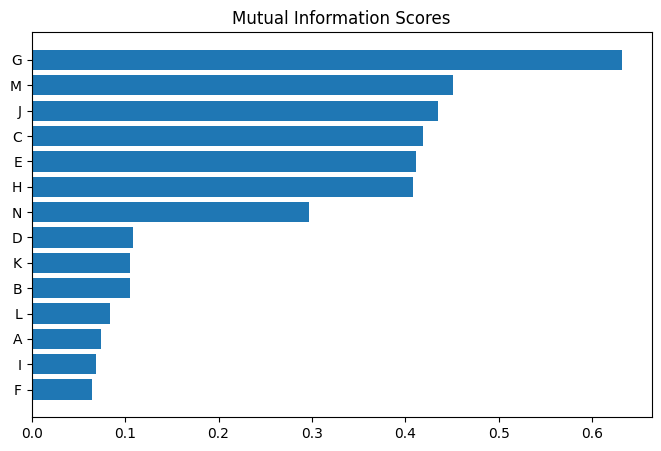

In [4]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [5]:
y = train_data["Y2"]

mi_scores = make_mi_scores(X, y)

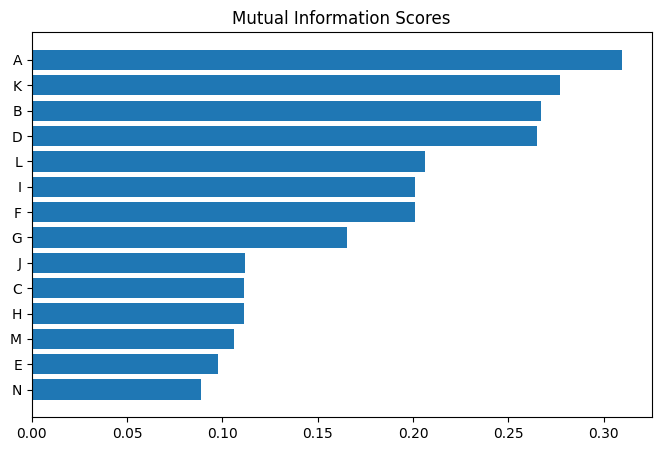

In [6]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

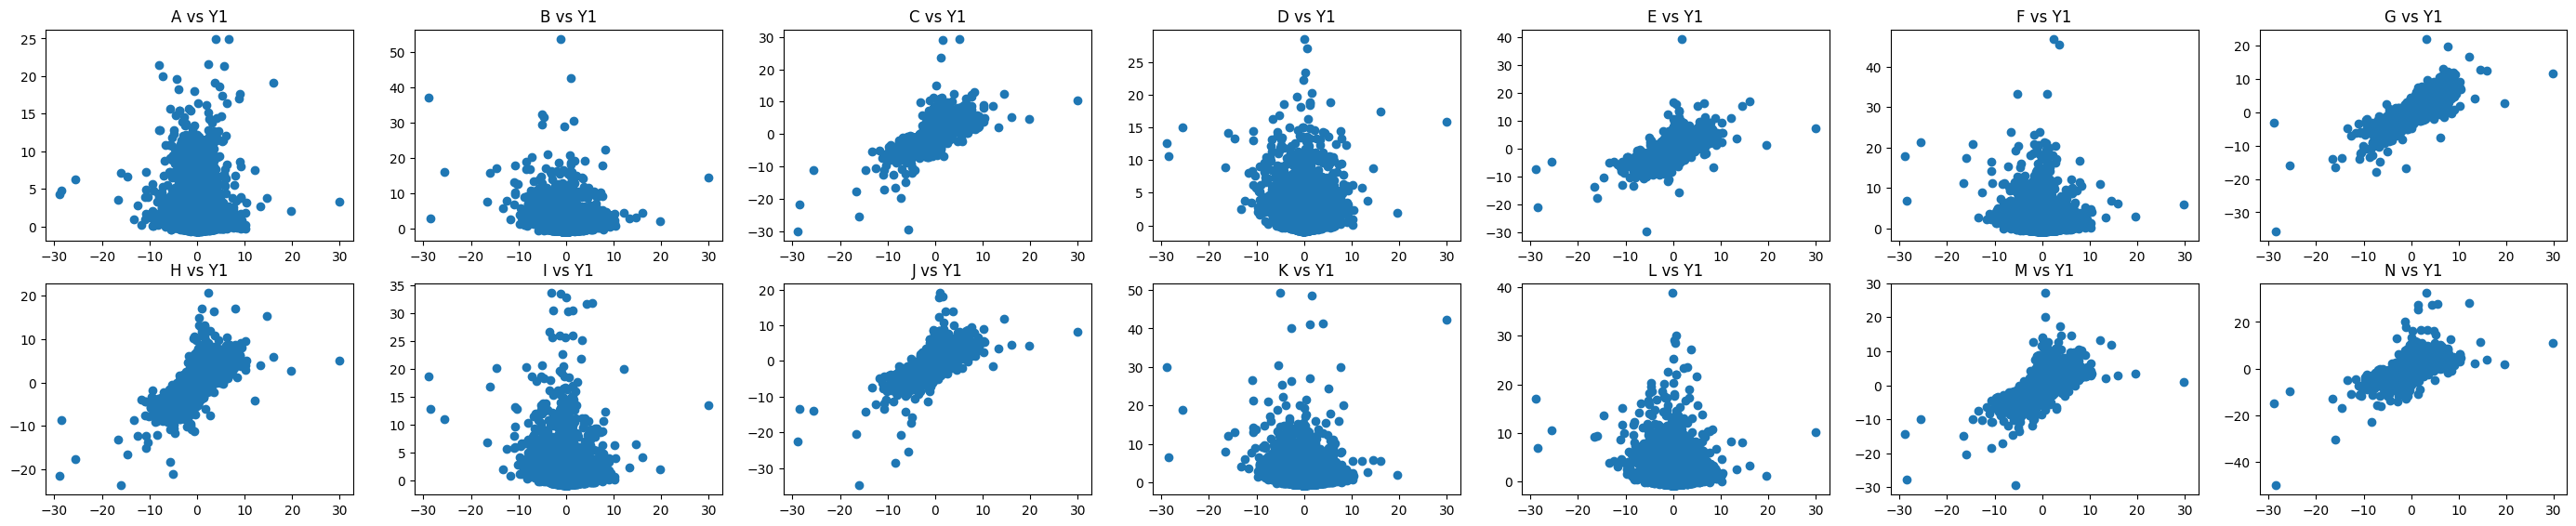

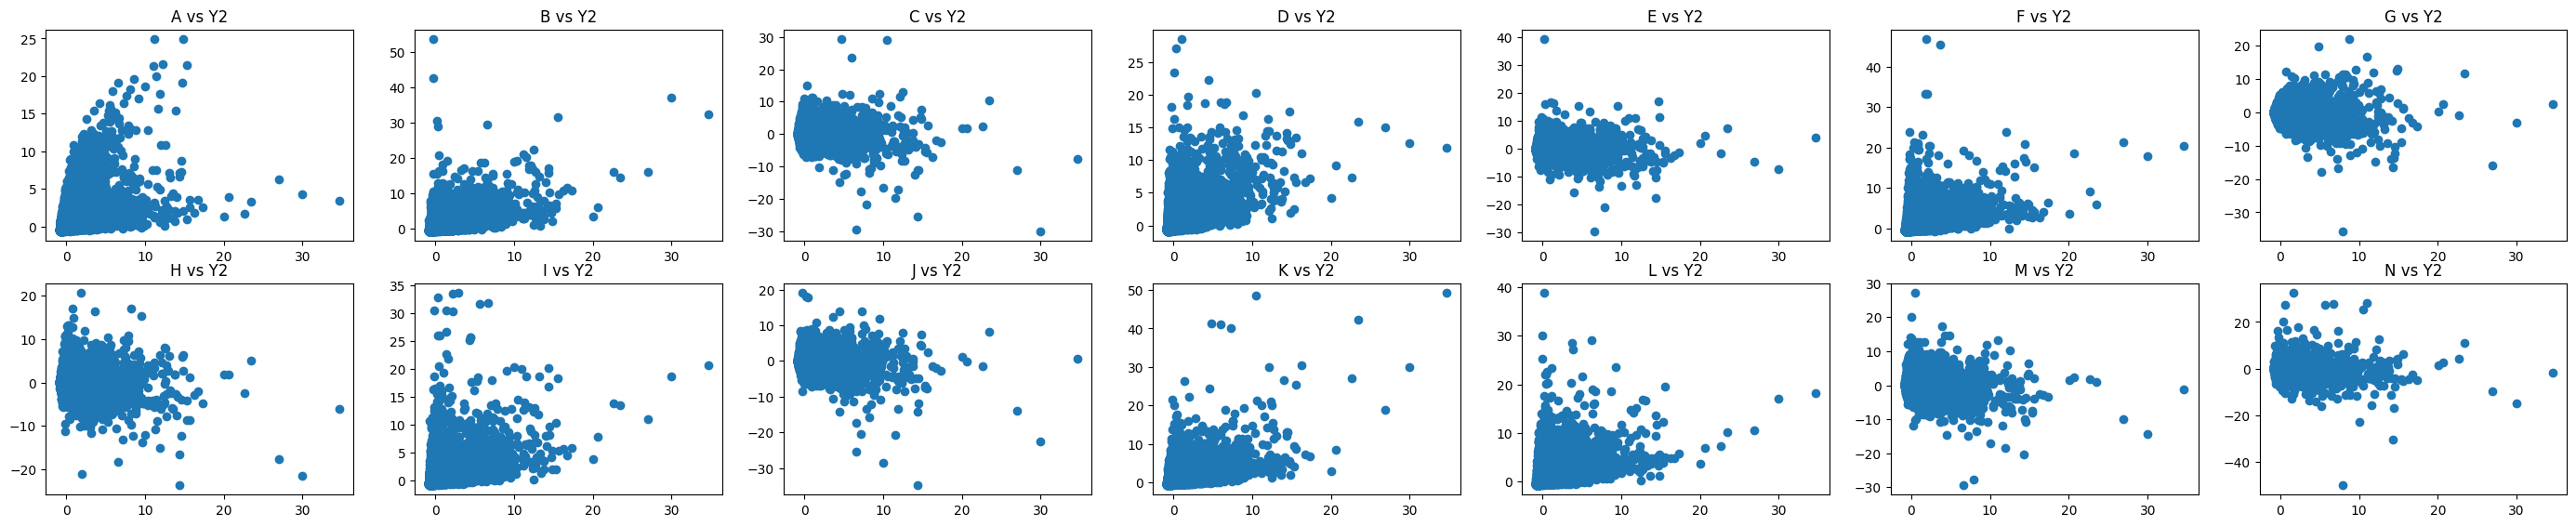

In [7]:
def plot_rels(features, target, nrows = 2, ncols = 7):
    fig, axs = plt.subplots(nrows = nrows, ncols = ncols, sharex=False, sharey=False, squeeze=False, figsize = [ncols * 5, nrows * 3 + 0.5])

    for i in range(nrows):
        for j in range(ncols):
            axs[i,j].scatter(train_data[target], (train_data[features[i][j]].values), )
            axs[i,j].set_title(f"{features[i][j]} vs {target}")

    return fig

features = ["A", "B", "C", "D", "E", "F", "G"], ["H", "I", "J", "K", "L", "M", "N"]

plot_rels(features, "Y1")

plot_rels(features, "Y2")

plt.show()

Okay, we have some linear correlations in Y1, but Y2 is a lot more complicated, we want to run PCA to analyse underlying;

In [8]:
from sklearn.decomposition import PCA

A = train_data.drop(["time", "Y1", "Y2"], axis=1)

A_scaled = (A.values - np.mean(A.values)) / np.std(A.values) # Standardising before PCA

pca = PCA(n_components= 3)

A_pca = pca.fit_transform(A_scaled)

print(pca.explained_variance_ratio_)

A_pca[:,0] = -A_pca[:,0]

[0.34330848 0.24878093 0.07225697]


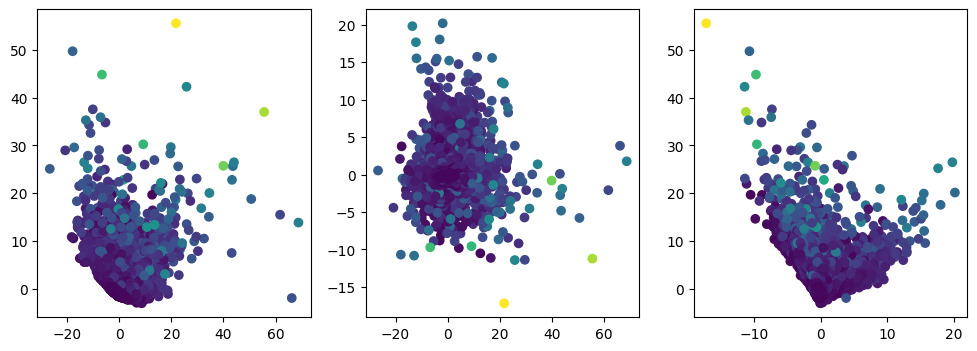

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = [12, 4])

ax1.scatter(A_pca[:,0], A_pca[:,1], c=train_data["Y2"], cmap="viridis")
ax2.scatter(A_pca[:,0], A_pca[:,2], c=train_data["Y2"], cmap="viridis")
ax3.scatter(A_pca[:,2], A_pca[:,1], c=train_data["Y2"], cmap="viridis")

plt.show()

In [10]:
pcs = pd.DataFrame(A_pca, columns=["PC1", "PC2", "PC3"])
corrs = pcs.corrwith(train_data["Y2"])
print(corrs)

PC1    0.287773
PC2    0.703791
PC3    0.169426
dtype: float64


In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X = pcs[["PC1" ,"PC2", "PC3"]]

y = train_data["Y2"]

X_train, X_val, y_train, y_val = train_test_split(X, y)

modelY2 = RandomForestRegressor(n_estimators=200)

modelY2.fit(X_train, y_train)

y_pred = modelY2.predict(X_val)

r2_score(y_pred, y_val)

0.38890024508968246

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X = train_data[["G", "M", "J", "C", "E", "H", "N"]]

y = train_data["Y1"]

X_train, X_val, y_train, y_val = train_test_split(X, y)

modelY1 = RandomForestRegressor(n_estimators=100)

modelY1.fit(X_train, y_train)

y_pred = modelY1.predict(X_val)

r2_score(y_pred, y_val)

0.6865063053043503

Let's create a Pipeline for applying this PCA shift and getting our prediction values

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

pipelineY2 = Pipeline([
    ("pca", PCA(n_components = 3)),
    ("model", RandomForestRegressor(n_estimators = 100))
])

X = train_data.drop(["time", "Y1", "Y2"], axis = 1)
y = train_data["Y2"]

X_train, X_val, y_train, y_val = train_test_split(X, y)

pipelineY2.fit(X_train, y_train)

y_pred = pipelineY2.predict(X_val)

r2_score(y_pred, y_val)

0.4183263151512573

Okay... this is not ideal, but let's now have a look at autocorrelation.

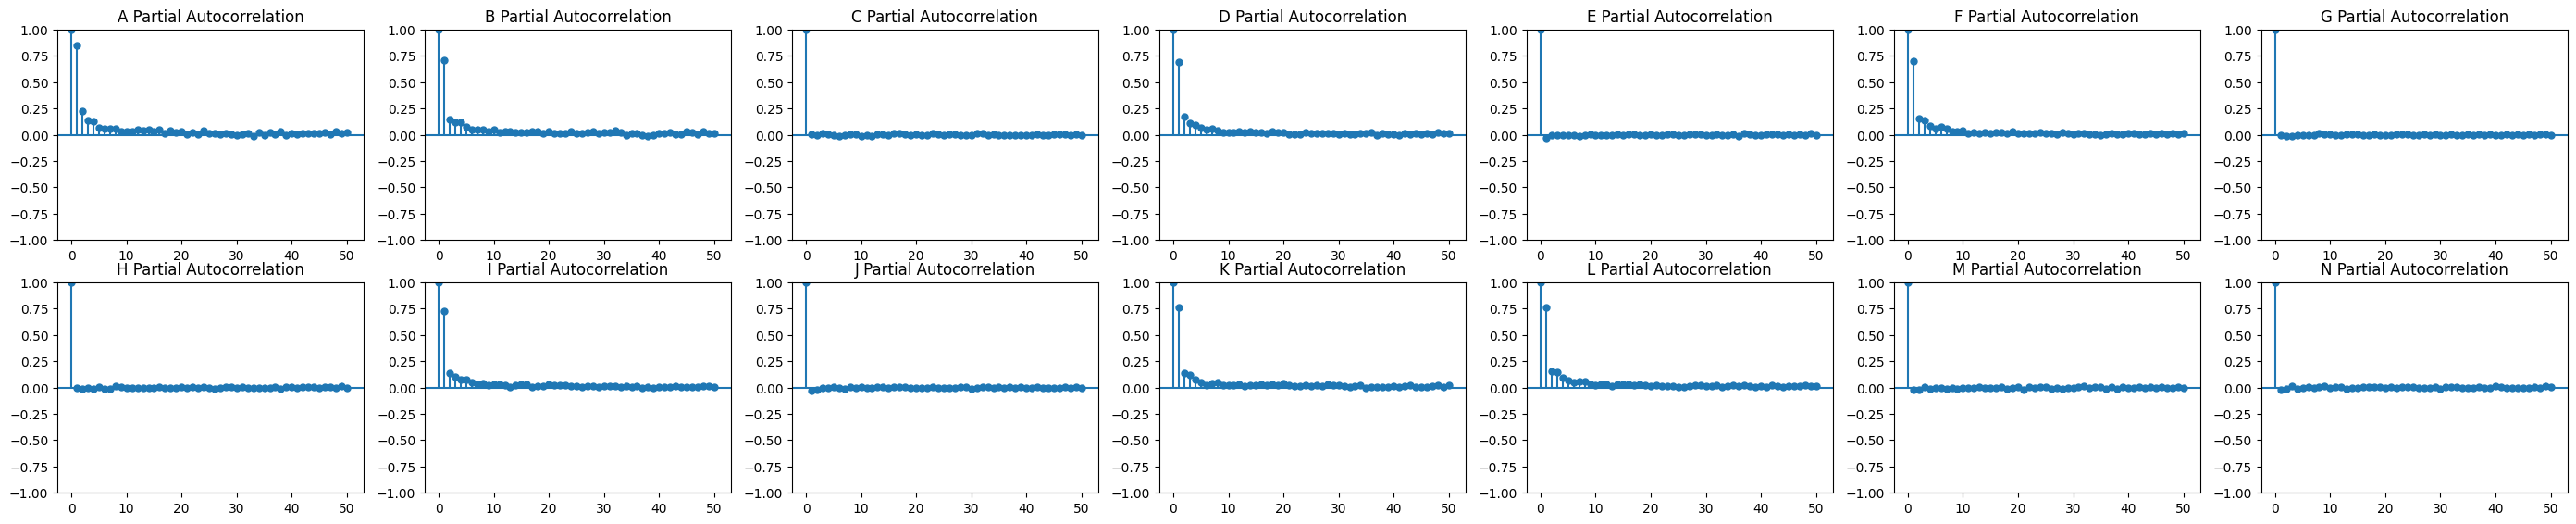

In [14]:
from statsmodels.graphics.tsaplots import plot_pacf

def plot_pacfs(features, nrows = 2, ncols = 7):
    fig, axs = plt.subplots(nrows = nrows, ncols = ncols, sharex=False, sharey=False, squeeze=False, figsize = [ncols * 5, nrows * 3 + 0.5])

    for i in range(nrows):
        for j in range(ncols):
            plot_pacf(train_data[features[i][j]].values, axs[i,j], title = f"{features[i][j]} Partial Autocorrelation")

    return fig

features = [["A", "B", "C", "D", "E", "F", "G"], ["H", "I", "J", "K", "L", "M", "N"]]

plot_pacfs(features)

plt.show()

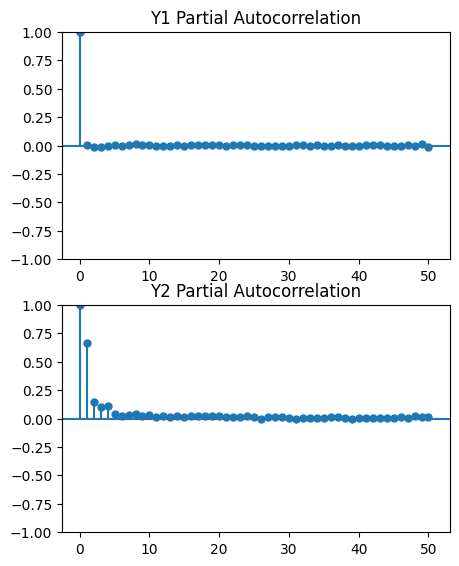

In [15]:
plot_pacfs([["Y1"],["Y2"]], nrows = 2, ncols = 1)

plt.show()